In [1]:
import pandas as pd
import os, sys
from datetime import datetime
import matplotlib.pyplot as plt

sys.path.append('../')

from src.functions import *

gs_uri = 'gs://videotron-ai-bucket/'
dataset_path = gs_uri + 'dataset/'

In [2]:
mep_df = pd.read_csv(dataset_path + 'MEP_Videotron.csv', encoding="ISO-8859-1", low_memory=False)

mep_df = mep_df.dropna(subset=['ScheduledStartDate'])
mep_df['mep_date'] = mep_df['ActualStartDate']
mep_df['mep_started'] = (~mep_df['ActualStartDate'].isna())
mep_df.loc[mep_df['ActualStartDate'].isna(), 'mep_date'] = mep_df.loc[mep_df['ActualStartDate'].isna(), 'ScheduledStartDate']

mep_df = cast_mep_dates(mep_df)

start_dt = datetime.strptime('2017-10-01', '%Y-%m-%d')
cond = (mep_df['mep_date'] >= start_dt)

agg_df = mep_df.loc[cond].groupby('mep_date_day')['mep_date_day'].count()
agg_df = pd.DataFrame(agg_df.values, index=agg_df.index, columns=['total_mep_cnt'])
agg_df = build_lag_features(agg_df, 'total_mep_cnt')

for col in ['Risk_Level','ChangeType', 'Urgency', 'Impact',	'Priority']:
    for val in mep_df[col].value_counts().index:    
        col_agg = f'{col}_{val}_cnt'
        cond_risk = (cond & (mep_df[col] == val))
        agg_df[col_agg] = mep_df.loc[cond].groupby('mep_date_day')[col].agg(lambda x: count_mep(x, val))
        
        # build lag features
        agg_df = build_lag_features(agg_df, col_agg)

In [3]:
agg_df

,total_mep_cnt,total_mep_cnt lag_1,total_mep_cnt lag_2,total_mep_cnt lag_3,total_mep_cnt lag_4,total_mep_cnt lag_5,total_mep_cnt lag_6,total_mep_cnt lag_7,total_mep_cnt lag_14,total_mep_cnt lag_21,...,Priority_0_cnt lag_1,Priority_0_cnt lag_2,Priority_0_cnt lag_3,Priority_0_cnt lag_4,Priority_0_cnt lag_5,Priority_0_cnt lag_6,Priority_0_cnt lag_7,Priority_0_cnt lag_14,Priority_0_cnt lag_21,Priority_0_cnt lag_28
mep_date_day,,,,,,,,,,,,,,,,,,,,,
2017-10-11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-01,10,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-02,20,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-03,22,20.0,10.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-11-04,1,22.0,20.0,10.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03,1,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-01,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-01-05,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


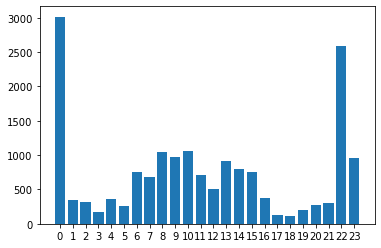

In [22]:
y = mep_df['ActualStartDate'].apply(lambda x: x.hour).value_counts().values
x = mep_df['ActualStartDate'].apply(lambda x: x.hour).value_counts().index


plt.bar(x, y)
plt.xticks(x, rotation=0)
plt.show()

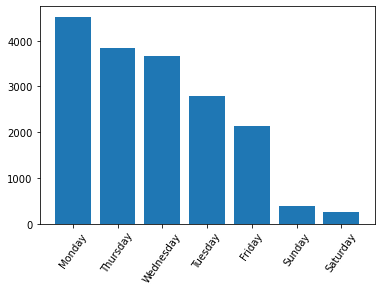

In [19]:
y = mep_df['ActualStartDate'].apply(lambda x: x.day_name()).value_counts().values
x = mep_df['ActualStartDate'].apply(lambda x: x.day_name()).value_counts().index

plt.bar(x, y)
plt.xticks(x, rotation=55)
plt.show()